<a href="https://www.kaggle.com/code/avtnshm/clinical-modernbert-v-biomedicalmb-on-ddxplus-data?scriptVersionId=287957344" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# Step 1: Load Data

import pandas as pd
import numpy as np
import json

train_df = pd.read_csv('/kaggle/input/mldataset/ddxplus/train.csv')
test_df = pd.read_csv('/kaggle/input/mldataset/ddxplus/test.csv')
validate_df = pd.read_csv('/kaggle/input/mldataset/ddxplus/validate.csv')

print(train_df.shape, validate_df.shape, test_df.shape)

(1025602, 6) (132448, 6) (134529, 6)


In [2]:
with open('/kaggle/input/mldataset/ddxplus/release_evidences.json') as f:
    evidences = json.load(f)

evidences_df = pd.DataFrame.from_dict(evidences, orient='index')

In [3]:
def codes_to_text(evidence_str):
    if not isinstance(evidence_str, str):
        return ""
    parts = [c.strip() for c in evidence_str.split(";")]
    mapped = [evidences_df.loc[p, "question_en"] for p in parts if p in evidences_df.index]
    return " ".join(mapped)

In [4]:
train_df["TEXT"] = train_df["EVIDENCES"].apply(codes_to_text)
validate_df["TEXT"] = validate_df["EVIDENCES"].apply(codes_to_text)
test_df["TEXT"] = test_df["EVIDENCES"].apply(codes_to_text)

In [5]:
from sklearn.model_selection import train_test_split

train_30, _ = train_test_split(
    train_df,
    test_size=0.70,
    stratify=train_df["PATHOLOGY"],
    random_state=42
)

valid_30, _ = train_test_split(
    validate_df,
    test_size=0.70,
    stratify=validate_df["PATHOLOGY"],
    random_state=42
)

test_30, _ = train_test_split(
    test_df,
    test_size=0.70,
    stratify=test_df["PATHOLOGY"],
    random_state=42
)

print(train_30.shape, valid_30.shape, test_30.shape)

(307680, 7) (39734, 7) (40358, 7)


In [6]:
!pip install -q transformers
import torch
from transformers import AutoTokenizer, AutoModel

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using:", device)

cmb_model = AutoModel.from_pretrained('Simonlee711/Clinical_ModernBERT').to(device)
cmb_tok = AutoTokenizer.from_pretrained('Simonlee711/Clinical_ModernBERT')

bmb_model = AutoModel.from_pretrained("thomas-sounack/BioClinical-ModernBERT-base").to(device)
bmb_tok = AutoTokenizer.from_pretrained("thomas-sounack/BioClinical-ModernBERT-base")

Using: cuda


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/547M [00:00<?, ?B/s]

Some weights of BertModel were not initialized from the model checkpoint at Simonlee711/Clinical_ModernBERT and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/694 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/599M [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/693 [00:00<?, ?B/s]

In [7]:
def embed(text_list, tokenizer, model, batch_size=32):
    all_vecs = []

    for i in range(0, len(text_list), batch_size):
        batch = text_list[i:i+batch_size]
        inputs = tokenizer(batch, return_tensors="pt", padding=True, truncation=True, max_length=128).to(device)

        with torch.no_grad():
            out = model(**inputs).last_hidden_state[:,0,:]

        all_vecs.append(out.cpu().numpy())

    return np.vstack(all_vecs)

In [8]:
train_texts = train_30["TEXT"].tolist()
valid_texts = valid_30["TEXT"].tolist()
test_texts  = test_30["TEXT"].tolist()

cmb_train = embed(train_texts, cmb_tok, cmb_model)
bmb_train = embed(train_texts, bmb_tok, bmb_model)

W1223 06:31:01.672000 38 torch/_inductor/utils.py:1137] [1/0] Not enough SMs to use max_autotune_gemm mode


In [9]:
cmb_valid = embed(valid_texts, cmb_tok, cmb_model)
bmb_valid = embed(valid_texts, bmb_tok, bmb_model)

cmb_test = embed(test_texts, cmb_tok, cmb_model)
bmb_test = embed(test_texts, bmb_tok, bmb_model)

In [11]:
!pip install umap-learn -q


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [12]:
import numpy as np
import pandas as pd

# Number of samples for visualization
N = 5000

# Random indices
idx = np.random.choice(len(train_30), size=N, replace=False)

cmb_vis = cmb_train[idx]
bmb_vis = bmb_train[idx]
labels_vis = train_30["PATHOLOGY"].iloc[idx].values


In [13]:
import umap.umap_ as umap

reducer = umap.UMAP(n_neighbors=30, min_dist=0.1, metric="cosine")

cmb_2d = reducer.fit_transform(cmb_vis)
bmb_2d = reducer.fit_transform(bmb_vis)


In [ ]:
from sklearn.metrics import top_k_accuracy_score

pred_probs_cmb = clf_cmb.predict_proba(cmb_valid)
pred_probs_bmb = clf_bmb.predict_proba(bmb_valid)

print("CMB Top-3:", top_k_accuracy_score(y_valid, pred_probs_cmb, k=3))
print("BMB Top-3:", top_k_accuracy_score(y_valid, pred_probs_bmb, k=3))

In [15]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
labels_encoded = le.fit_transform(labels_vis)


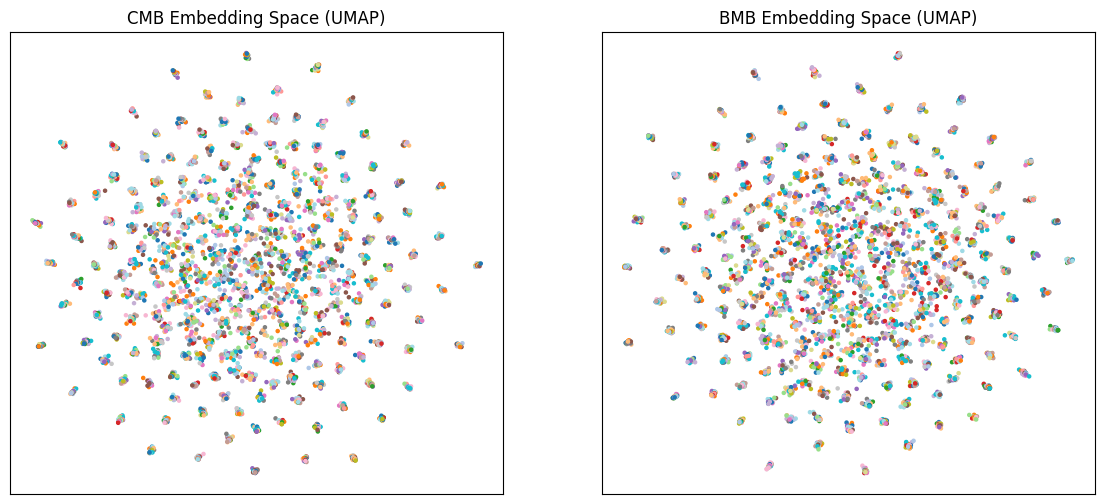

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14,6))

plt.subplot(1,2,1)
plt.scatter(cmb_2d[:,0], cmb_2d[:,1], c=labels_encoded, cmap="tab20", s=5)
plt.title("CMB Embedding Space (UMAP)")
plt.xticks([]); plt.yticks([])

plt.subplot(1,2,2)
plt.scatter(bmb_2d[:,0], bmb_2d[:,1], c=labels_encoded, cmap="tab20", s=5)
plt.title("BMB Embedding Space (UMAP)")
plt.xticks([]); plt.yticks([])

plt.show()


In [19]:
from sklearn.manifold import TSNE

tsne = TSNE(
    n_components=2,
    learning_rate="auto",
    perplexity=50,
    init="pca",
    random_state=42
)

cmb_tsne = tsne.fit_transform(cmb_vis)
bmb_tsne = tsne.fit_transform(bmb_vis)


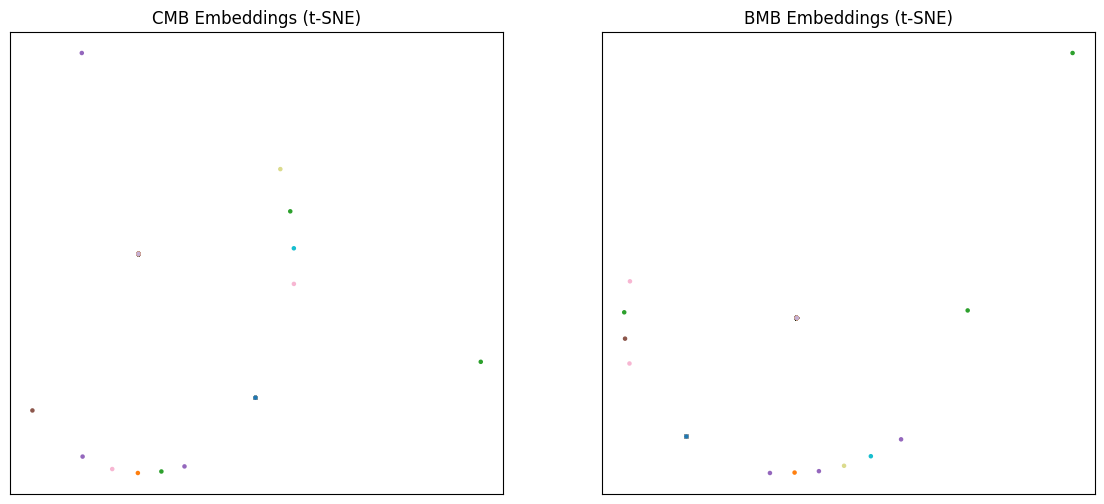

In [22]:
plt.figure(figsize=(14,6))

plt.subplot(1,2,1)
plt.scatter(cmb_tsne[:,0], cmb_tsne[:,1], c=labels_encoded, cmap="tab20", s=5)
plt.title("CMB Embeddings (t-SNE)")
plt.xticks([]); plt.yticks([])

plt.subplot(1,2,2)
plt.scatter(bmb_tsne[:,0], bmb_tsne[:,1], c=labels_encoded, cmap="tab20", s=5)
plt.title("BMB Embeddings (t-SNE)")
plt.xticks([]); plt.yticks([])

plt.show()


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, accuracy_score

y_train = train_30["PATHOLOGY"]
y_valid = valid_30["PATHOLOGY"]

clf_cmb = LogisticRegression(max_iter=200)
clf_cmb.fit(cmb_train, y_train)

pred_cmb = clf_cmb.predict(embed(valid_texts, cmb_tok, cmb_model))
print("CMB Macro F1:", f1_score(y_valid, pred_cmb, average='macro'))

In [ ]:
clf_bmb = LogisticRegression(max_iter=200)
clf_bmb.fit(bmb_train, y_train)

pred_bmb = clf_bmb.predict(embed(valid_texts, bmb_tok, bmb_model))
print("BMB Macro F1:", f1_score(y_valid, pred_bmb, average='macro'))

In [ ]:
from sklearn.neural_network import MLPClassifier

mlp_cmb = MLPClassifier(hidden_layer_sizes=(512,256), max_iter=20)
mlp_cmb.fit(cmb_train, y_train)
pred_cmb_mlp = mlp_cmb.predict_proba(cmb_valid)

print("CMB Top-3:", top_k_accuracy_score(y_valid, pred_cmb_mlp, k=3))
print("CMB Top-5:", top_k_accuracy_score(y_valid, pred_cmb_mlp, k=5))

In [ ]:
mlp_bmb = MLPClassifier(hidden_layer_sizes=(256,), max_iter=5)
mlp_bmb.fit(bmb_train, y_train)
pred_bmb_mlp = mlp_bmb.predict_proba(bmb_valid)

print("BMB Top-3:", top_k_accuracy_score(y_valid, pred_bmb_mlp, k=3))
print("BMB Top-5:", top_k_accuracy_score(y_valid, pred_bmb_mlp, k=5))

In [23]:
print("CMB Top-1:", top_k_accuracy_score(y_valid, pred_probs_cmb, k=1))
print("CMB Top-2:", top_k_accuracy_score(y_valid, pred_probs_cmb, k=2))
print("CMB Top-3:", top_k_accuracy_score(y_valid, pred_probs_cmb, k=3))
print("CMB Top-4:", top_k_accuracy_score(y_valid, pred_probs_cmb, k=4))
print("CMB Top-5:", top_k_accuracy_score(y_valid, pred_probs_cmb, k=5))

print("\nBMB Top-1:", top_k_accuracy_score(y_valid, pred_probs_bmb, k=1))
print("BMB Top-2:", top_k_accuracy_score(y_valid, pred_probs_bmb, k=2))
print("BMB Top-3:", top_k_accuracy_score(y_valid, pred_probs_bmb, k=3))
print("BMB Top-4:", top_k_accuracy_score(y_valid, pred_probs_bmb, k=4))
print("BMB Top-5:", top_k_accuracy_score(y_valid, pred_probs_bmb, k=5))


CMB Top-1: 0.0653596416167514
CMB Top-2: 0.12762369758896663
CMB Top-3: 0.17974530628680727
CMB Top-4: 0.2088387778728545
CMB Top-5: 0.23672421603664368

BMB Top-1: 0.0653596416167514
BMB Top-2: 0.12762369758896663
BMB Top-3: 0.17974530628680727
BMB Top-4: 0.2088387778728545
BMB Top-5: 0.23672421603664368


In [25]:
from sklearn.metrics import classification_report
import pandas as pd

report_cmb = classification_report(
    y_valid, pred_cmb, output_dict=True, zero_division=0
)

report_bmb = classification_report(
    y_valid, pred_bmb, output_dict=True, zero_division=0
)

df_cmb = pd.DataFrame(report_cmb).T
df_bmb = pd.DataFrame(report_bmb).T

df_cmb.head()


,precision,recall,f1-score,support
Acute COPD exacerbation / infection,0.0,0.0,0.0,623.0
Acute dystonic reactions,0.0,0.0,0.0,984.0
Acute laryngitis,0.0,0.0,0.0,1022.0
Acute otitis media,0.0,0.0,0.0,1042.0
Acute pulmonary edema,0.0,0.0,0.0,750.0


In [26]:
df_cmb.info()

<class 'pandas.core.frame.DataFrame'>
Index: 52 entries, Acute COPD exacerbation / infection to weighted avg
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   precision  52 non-null     float64
 1   recall     52 non-null     float64
 2   f1-score   52 non-null     float64
 3   support    52 non-null     float64
dtypes: float64(4)
memory usage: 2.0+ KB


In [28]:
def predict_topk(text, tokenizer, model, clf, k=5):
    vec = embed([text], tokenizer, model)[0].reshape(1,-1)
    probs = clf.predict_proba(vec)[0]
    topk_idx = probs.argsort()[-k:][::-1]
    return [(clf.classes_[i], probs[i]) for i in topk_idx]


In [29]:
case1 = "fever, productive cough, chest pain, shortness of breath"
print("CMB:", predict_topk(case1, cmb_tok, cmb_model, clf_cmb))
print("BMB:", predict_topk(case1, bmb_tok, bmb_model, clf_bmb))


CMB: [('URTI', 0.05410278627823117), ('Viral pharyngitis', 0.05215916367611489), ('Anemia', 0.04415358057913586), ('HIV (initial infection)', 0.027510886283201367), ('Localized edema', 0.02654934024737763)]
BMB: [('URTI', 0.04786296026191831), ('Viral pharyngitis', 0.04637951220946634), ('Anemia', 0.040203560104084955), ('HIV (initial infection)', 0.026785259906961113), ('Localized edema', 0.025980793054879055)]


In [30]:
case2 = "severe abdominal pain in right lower quadrant, nausea, vomiting, mild fever"
print("CMB:", predict_topk(case2, cmb_tok, cmb_model, clf_cmb))
print("BMB:", predict_topk(case2, bmb_tok, bmb_model, clf_bmb))



CMB: [('URTI', 0.05067437527458331), ('Viral pharyngitis', 0.04899052749537948), ('Anemia', 0.04200206481723012), ('HIV (initial infection)', 0.02713257918488735), ('Localized edema', 0.026255452816059947)]
BMB: [('URTI', 0.04823587064593772), ('Viral pharyngitis', 0.046725699743756295), ('Anemia', 0.04044403630981262), ('HIV (initial infection)', 0.02683292675965686), ('Localized edema', 0.02601884932665171)]


In [31]:
import shutil
shutil.rmtree("/kaggle/working", ignore_errors=True)
